<a href="https://colab.research.google.com/github/Tkaheva/MO/blob/main/homework_practice_5_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Урок 4. Метрики качества классификации ч.2

Продолжим работу с метриками классификации. В предыдущем задании мы разобрали матрицу ошибок и две основные метрики, которые используются при бинарной классификации.

Сейчас рассмотрим F-меру - совокупную метрику по precision и recall - и более сложную AUC-ROC.

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, recall_score

# Загрузка данных
try:
    df = pd.read_csv('train.csv')
except:
    url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
    df = pd.read_csv(url)

# Подготовка данных
# Заполнение пропущенных значений
male_median = df[df['Sex'] == 'male']['Age'].median()
female_median = df[df['Sex'] == 'female']['Age'].median()

def fill_age(row):
    if pd.isnull(row['Age']):
        if row['Sex'] == 'male':
            return male_median
        else:
            return female_median
    return row['Age']

df['Age'] = df.apply(fill_age, axis=1)
df['Cabin'] = df['Cabin'].fillna('U')
df['Embarked'] = df['Embarked'].fillna('U')

# Преобразование категориальных признаков
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
embarked_mapping = {'U': 0, 'S': 1, 'C': 2, 'Q': 3}
df['Embarked'] = df['Embarked'].map(embarked_mapping)
df_processed = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

# Разделение данных
X = df_processed.drop('Survived', axis=1)
y = df_processed['Survived']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=17, stratify=y
)

# Обучение классификаторов
models = {
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=17),
    'Logistic Regression': LogisticRegression(random_state=17, max_iter=1000)
}

trained_models = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    trained_models[name] = model
    print(f"{name}: обучен")

# Теперь выполняем код из урока 4
print("="*50)
print("2.1 Классификатор с наименьшим recall и расчет F1-меры")
print("="*50)

# Найдем модель с наименьшим recall
from sklearn.metrics import precision_score, f1_score

worst_model_name = None
worst_recall = 1.0
recall_values = {}

for name, model in trained_models.items():
    y_pred = model.predict(X_test)
    current_recall = recall_score(y_test, y_pred)
    recall_values[name] = current_recall
    if current_recall < worst_recall:
        worst_recall = current_recall
        worst_model_name = name

print(f"Модель с наименьшим recall: {worst_model_name}")
print(f"Recall: {worst_recall:.4f}")

# Вычисляем precision для этой модели
worst_model = trained_models[worst_model_name]
y_pred_worst = worst_model.predict(X_test)
precision_worst = precision_score(y_test, y_pred_worst)
print(f"Precision для {worst_model_name}: {precision_worst:.4f}")

# Ручной расчет F1-меры
manual_f1 = 2 * (precision_worst * worst_recall) / (precision_worst + worst_recall) if (precision_worst + worst_recall) > 0 else 0
print(f"Ручной расчет F1-меры: 2 * ({precision_worst:.4f} * {worst_recall:.4f}) / ({precision_worst:.4f} + {worst_recall:.4f}) = {manual_f1:.4f}")

# Проверка через sklearn
sklearn_f1 = f1_score(y_test, y_pred_worst)
print(f"Sklearn F1-мера: {sklearn_f1:.4f}")
print(f"Совпадают: {abs(manual_f1 - sklearn_f1) < 0.0001}")

# Сравнение со средним арифметическим
arithmetic_mean = (precision_worst + worst_recall) / 2
print(f"\nСравнение:")
print(f"F1-мера: {manual_f1:.4f}")
print(f"Среднее арифметическое precision и recall: {arithmetic_mean:.4f}")
print(f"Разница: {abs(manual_f1 - arithmetic_mean):.4f}")
print(f"F1-мера {'>' if manual_f1 > arithmetic_mean else '<'} среднего арифметического")
print("\nВывод: F1-мера - это гармоническое среднее, которое всегда меньше или равно")
print("среднего арифметического для положительных чисел (неравенство Коши).")

KNN: обучен
Naive Bayes: обучен
Decision Tree: обучен
Logistic Regression: обучен
2.1 Классификатор с наименьшим recall и расчет F1-меры
Модель с наименьшим recall: KNN
Recall: 0.6163
Precision для KNN: 0.6709
Ручной расчет F1-меры: 2 * (0.6709 * 0.6163) / (0.6709 + 0.6163) = 0.6424
Sklearn F1-мера: 0.6424
Совпадают: True

Сравнение:
F1-мера: 0.6424
Среднее арифметическое precision и recall: 0.6436
Разница: 0.0012
F1-мера < среднего арифметического

Вывод: F1-мера - это гармоническое среднее, которое всегда меньше или равно
среднего арифметического для положительных чисел (неравенство Коши).


### 2.1
Из задания к предыдущему уроку выберите классификатор, который давал наименьшее значение recall, вычислите для него precision, применив precision_score, и самостоятельно посчитайте F1-меру (расчеты должны присутствовать). Затем проверьте ответ, используя встроенную функцию.

Сравните полученную f1-меру со значением среднего арифметического полноты и точности.

In [5]:
from sklearn.metrics import precision_score, f1_score

In [4]:
print("="*50)
print("2.1 Классификатор с наименьшим recall и расчет F1-меры")
print("="*50)

# Найдем модель с наименьшим recall
from sklearn.metrics import precision_score, f1_score, recall_score

worst_model_name = None
worst_recall = 1.0
recall_values = {}

for name, model in trained_models.items():
    y_pred = model.predict(X_test)
    current_recall = recall_score(y_test, y_pred)
    recall_values[name] = current_recall
    if current_recall < worst_recall:
        worst_recall = current_recall
        worst_model_name = name

print(f"Модель с наименьшим recall: {worst_model_name}")
print(f"Recall: {worst_recall:.4f}")

# Вычисляем precision для этой модели
worst_model = trained_models[worst_model_name]
y_pred_worst = worst_model.predict(X_test)
precision_worst = precision_score(y_test, y_pred_worst)
print(f"Precision для {worst_model_name}: {precision_worst:.4f}")

# Ручной расчет F1-меры
manual_f1 = 2 * (precision_worst * worst_recall) / (precision_worst + worst_recall) if (precision_worst + worst_recall) > 0 else 0
print(f"Ручной расчет F1-меры: 2 * ({precision_worst:.4f} * {worst_recall:.4f}) / ({precision_worst:.4f} + {worst_recall:.4f}) = {manual_f1:.4f}")

# Проверка через sklearn
sklearn_f1 = f1_score(y_test, y_pred_worst)
print(f"Sklearn F1-мера: {sklearn_f1:.4f}")
print(f"Совпадают: {abs(manual_f1 - sklearn_f1) < 0.0001}")

# Сравнение со средним арифметическим
arithmetic_mean = (precision_worst + worst_recall) / 2
print(f"\nСравнение:")
print(f"F1-мера: {manual_f1:.4f}")
print(f"Среднее арифметическое precision и recall: {arithmetic_mean:.4f}")
print(f"Разница: {abs(manual_f1 - arithmetic_mean):.4f}")
print(f"F1-мера {'>' if manual_f1 > arithmetic_mean else '<'} среднего арифметического")
print("\nВывод: F1-мера - это гармоническое среднее, которое всегда меньше или равно")
print("среднего арифметического для положительных чисел (неравенство Коши).")


2.1 Классификатор с наименьшим recall и расчет F1-меры
Модель с наименьшим recall: KNN
Recall: 0.6163
Precision для KNN: 0.6709
Ручной расчет F1-меры: 2 * (0.6709 * 0.6163) / (0.6709 + 0.6163) = 0.6424
Sklearn F1-мера: 0.6424
Совпадают: True

Сравнение:
F1-мера: 0.6424
Среднее арифметическое precision и recall: 0.6436
Разница: 0.0012
F1-мера < среднего арифметического

Вывод: F1-мера - это гармоническое среднее, которое всегда меньше или равно
среднего арифметического для положительных чисел (неравенство Коши).


В библиотеке sklearn есть удобная функция classification_report, возвращающая precision, recall, F-меру и количество экземпляров каждого класса в удобном для чтения формате. Также существует функция precision_recall_fscore_support, возвращающая те же самые метрики, но в форме массива.

### 2.2
Для каждого классификатора из предыдущего урока рассчитайте и выведите следующие импортированные метрики.

In [6]:
from sklearn.metrics import precision_recall_fscore_support, classification_report

In [7]:
print("\n" + "="*50)
print("2.2 Метрики для всех классификаторов")
print("="*50)

from sklearn.metrics import precision_recall_fscore_support, classification_report

for name, model in trained_models.items():
    y_pred = model.predict(X_test)

    print(f"\n{name}:")
    print("-" * 40)

    # Использование precision_recall_fscore_support
    precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average='binary')
    print(f"precision_recall_fscore_support:")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-score: {f1:.4f}")
    print(f"  Support: {support}")

    # Использование classification_report
    print(f"\nclassification_report:")
    print(classification_report(y_test, y_pred, target_names=['Not Survived', 'Survived']))



2.2 Метрики для всех классификаторов

KNN:
----------------------------------------
precision_recall_fscore_support:
  Precision: 0.6709
  Recall: 0.6163
  F1-score: 0.6424
  Support: None

classification_report:
              precision    recall  f1-score   support

Not Survived       0.77      0.81      0.79       137
    Survived       0.67      0.62      0.64        86

    accuracy                           0.74       223
   macro avg       0.72      0.71      0.72       223
weighted avg       0.73      0.74      0.73       223


Naive Bayes:
----------------------------------------
precision_recall_fscore_support:
  Precision: 0.7308
  Recall: 0.6628
  F1-score: 0.6951
  Support: None

classification_report:
              precision    recall  f1-score   support

Not Survived       0.80      0.85      0.82       137
    Survived       0.73      0.66      0.70        86

    accuracy                           0.78       223
   macro avg       0.77      0.75      0.76       223
wei

Вернемся к классификатору LogisticRegression, который мы обучали в предыдущем задании. Там мы не затрагивали настройку гиперпараметров: сделать это можно с помощью LogisticRegressionCV - перебора параметров по сетке с последующей кросс-валидацией (по сути это аналог GridSearchCV, но со своими параметрами внутри, применимыми только к логистической регрессии). Этот класс создан специально для логистической регрессии, т.к. для нее известны эффективные алгоритмы перебора параметров.

У LogisticRegression есть гиперпараметр C - обратный коэффициент регуляризации. Не вдаваясь в подробное описание по формуле, можно сказать, что C соответствует "сложности" модели: чем больше C, тем более сложные зависимости может восстанавливать модель; если параметр C слишком мал (слишком сильная регуляризация), то модель окажется недообученной, а если наоборот регуляризация слишком слабая (т.е. C принимает большие значения), то скорее всего модель окажется переобученной, потому как модель будет слишком "бояться" ошибиться на обучающей выборке.

### 2.3

1. Используя StratifiedKFold, разбейте данные для кросс-валидации по 5-ти блокам (не забывайте во всех методах использовать random_state=17).
2. С помощью numpy.logspace разбейте интервал (-1, 2) на 500 значений.
3. С помощью LogisticRegressionCV подберите оптимальный параметр C: установите гиперпараметр Cs равным объекту из п.2 (разбиение интервала (-1, 2) отвечает за подбор обратного коэффициента регуляризации C); cv равным объекту из п.1 (разбиение для кросс-валидации); scoring равным "roc_auc" (отвечает за оптимизацию гиперпараметров на кросс-валидации: метрика, установленная в scoring, контролирует, как оценивать модель при каждом из наборе параметров, т.е. показывает, какая метрика должна быть наилучшей).
4. Обучите полученную модель на тренировочных данных.

In [8]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV
import numpy as np

In [9]:
print("\n" + "="*50)
print("2.3 Подбор оптимального C для LogisticRegression")
print("="*50)

from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV
import numpy as np

# 1. Разбиение для кросс-валидации
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

# 2. Создание диапазона значений C
Cs = np.logspace(-1, 2, 500)  # 500 значений от 10^-1 до 10^2
print(f"Диапазон C: от {Cs[0]:.6f} до {Cs[-1]:.2f}")
print(f"Количество значений C: {len(Cs)}")

# 3. Создание и обучение модели LogisticRegressionCV
logit_cv = LogisticRegressionCV(
    Cs=Cs,
    cv=skf,
    scoring='roc_auc',
    random_state=17,
    max_iter=1000,
    n_jobs=-1
)

print("Обучение LogisticRegressionCV...")
logit_cv.fit(X_train, y_train)

print("Обучение завершено!")
print(f"Оптимальное значение C: {logit_cv.C_[0]:.6f}")
print(f"Лучшая оценка ROC-AUC: {logit_cv.scores_[1].mean(axis=0).max():.4f}")



2.3 Подбор оптимального C для LogisticRegression
Диапазон C: от 0.100000 до 100.00
Количество значений C: 500
Обучение LogisticRegressionCV...
Обучение завершено!
Оптимальное значение C: 0.217107
Лучшая оценка ROC-AUC: 0.8626


### 2.4
Используя метод plot из matplotlib.pyplot, выведите график зависимости auc_roc от значения C.

*Примечание: значения по оси x - разбиение с помощью np.logspace из п.2 предыдущего задания, а значения по оси y - среднее значение roc_auc по каждой валидации, т.е. среднее значение из полученных на каждом из 5-ти разбиений при данном параметре C (используйте метод scores_ объекта, который инкапсулирует LogisticRegressionCV).*

In [10]:
import matplotlib.pyplot as plt


2.4 График зависимости AUC-ROC от C


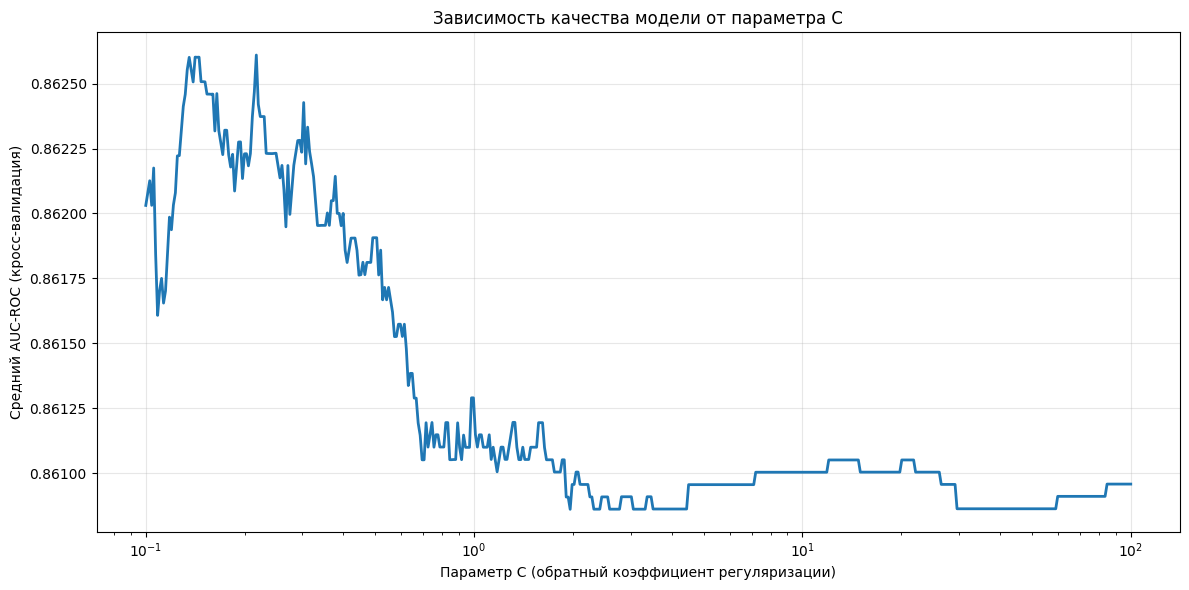

In [11]:
print("\n" + "="*50)
print("2.4 График зависимости AUC-ROC от C")
print("="*50)

import matplotlib.pyplot as plt

# Получаем средние значения AUC-ROC для каждого C
mean_scores = logit_cv.scores_[1].mean(axis=0)

plt.figure(figsize=(12, 6))
plt.plot(Cs, mean_scores, linewidth=2)
plt.xlabel('Параметр C (обратный коэффициент регуляризации)')
plt.ylabel('Средний AUC-ROC (кросс-валидация)')
plt.title('Зависимость качества модели от параметра C')
plt.grid(True, alpha=0.3)
plt.xscale('log')  # Логарифмическая шкала для оси X
plt.tight_layout()
plt.show()

### 2.5
С помощью метода C_ того же объекта выведите лучшее значение C. Выведите более конкретную область графика (область ~15 точкам по x), включающую лучшее значение C.

*Примечание: используйте plt.xlim.*


2.5 Лучшее значение C и увеличенная область графика
Лучшее значение C: 0.217107


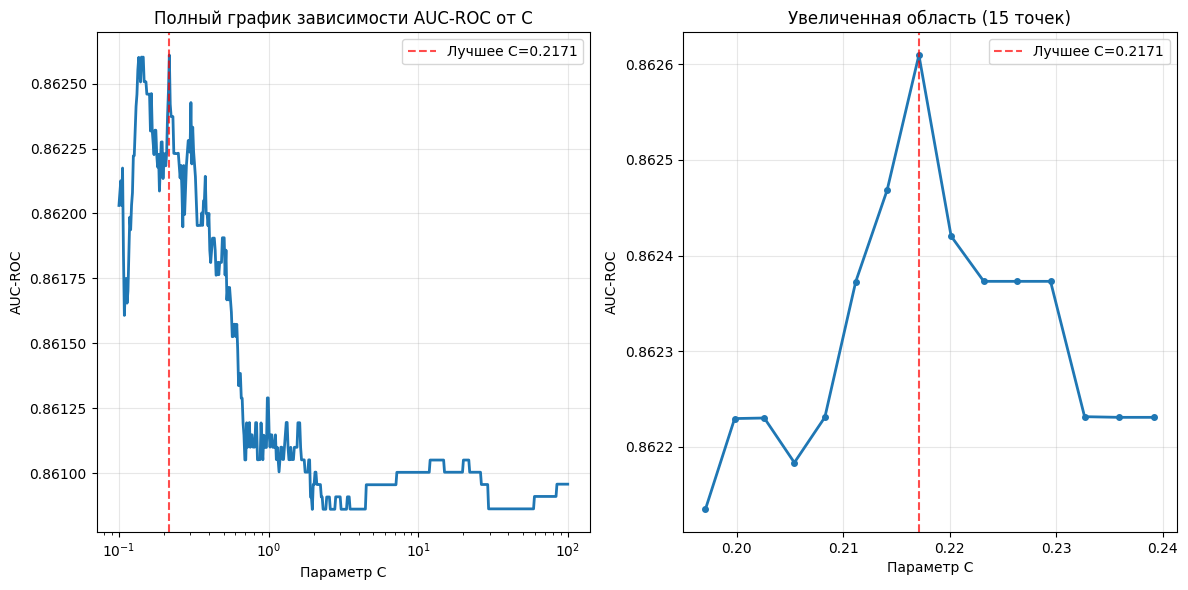

In [12]:
print("\n" + "="*50)
print("2.5 Лучшее значение C и увеличенная область графика")
print("="*50)

best_C = logit_cv.C_[0]
print(f"Лучшее значение C: {best_C:.6f}")

# Находим индекс лучшего значения C
best_idx = np.argmin(np.abs(Cs - best_C))

# Определяем область для увеличения (15 точек вокруг лучшего значения)
start_idx = max(0, best_idx - 7)
end_idx = min(len(Cs), best_idx + 8)

plt.figure(figsize=(12, 6))

# Полный график
plt.subplot(1, 2, 1)
plt.plot(Cs, mean_scores, linewidth=2)
plt.axvline(x=best_C, color='r', linestyle='--', alpha=0.7, label=f'Лучшее C={best_C:.4f}')
plt.xlabel('Параметр C')
plt.ylabel('AUC-ROC')
plt.title('Полный график зависимости AUC-ROC от C')
plt.xscale('log')
plt.grid(True, alpha=0.3)
plt.legend()

# Увеличенная область
plt.subplot(1, 2, 2)
plt.plot(Cs[start_idx:end_idx], mean_scores[start_idx:end_idx],
         marker='o', linewidth=2, markersize=4)
plt.axvline(x=best_C, color='r', linestyle='--', alpha=0.7, label=f'Лучшее C={best_C:.4f}')
plt.xlabel('Параметр C')
plt.ylabel('AUC-ROC')
plt.title(f'Увеличенная область ({len(Cs[start_idx:end_idx])} точек)')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()


### 2.6
С помощью метода predict_proba получите вероятности принадлежности объектов тестовой выборки к классам. Постройте график roc_auc для тестовой выборки и выведите значение auc.

**Пример** построения графика.

In [13]:
from sklearn.metrics import roc_auc_score, roc_curve

In [14]:
probas = logit_search.fit(x_train, y_train).predict_proba(x_train)
fpr, tpr, _ = roc_curve(y_train, probas[:, 1])
auc = roc_auc_score(y_train, probas[:, 1])
plt.plot(fpr, tpr, label="auc=" + str(auc))
plt.legend(loc=4)

NameError: name 'logit_search' is not defined


2.6 ROC-кривая для тестовой выборки


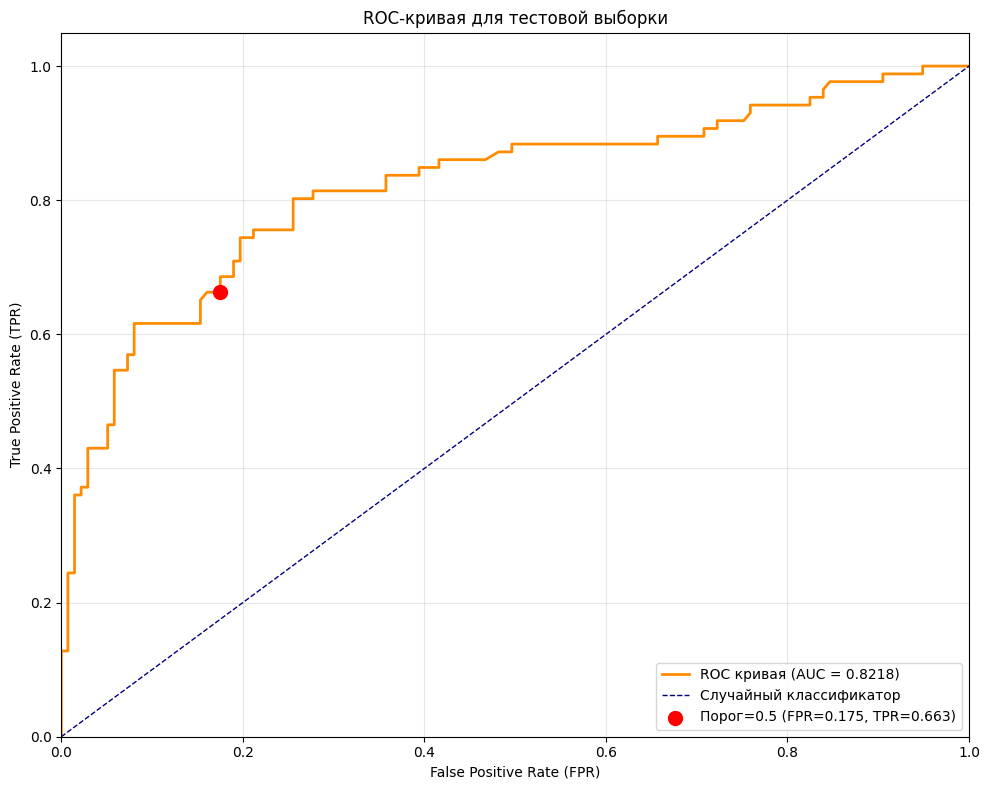

AUC-ROC для тестовой выборки: 0.8218

Сравнение с обычной LogisticRegression
LogisticRegression (без подбора C):
  C = 1.0
  AUC-ROC = 0.8239
  Recall = 0.6628
  Precision = 0.7037

LogisticRegressionCV (с подбором C):
  Лучшее C = 0.217107
  AUC-ROC = 0.8218
  Recall = 0.6628
  Precision = 0.7215

Улучшение AUC-ROC: -0.0021


In [15]:
print("\n" + "="*50)
print("2.6 ROC-кривая для тестовой выборки")
print("="*50)

from sklearn.metrics import roc_auc_score, roc_curve

# Получаем вероятности для тестовой выборки
y_proba = logit_cv.predict_proba(X_test)[:, 1]  # Вероятности положительного класса

# Рассчитываем метрики
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

# Строим ROC-кривую
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC кривая (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--', label='Случайный классификатор')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC-кривая для тестовой выборки')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# Добавляем точку оптимального порога (по умолчанию 0.5)
threshold_idx = np.argmin(np.abs(thresholds - 0.5))
plt.scatter(fpr[threshold_idx], tpr[threshold_idx],
            color='red', s=100, zorder=5, label=f'Порог=0.5 (FPR={fpr[threshold_idx]:.3f}, TPR={tpr[threshold_idx]:.3f})')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

print(f"AUC-ROC для тестовой выборки: {auc_score:.4f}")

# Дополнительно: сравнение с обычной логистической регрессией
print("\n" + "="*50)
print("Сравнение с обычной LogisticRegression")
print("="*50)

# Берем обычную LR из ранее обученных моделей
lr_model = trained_models['Logistic Regression']
y_pred_lr = lr_model.predict(X_test)
y_proba_lr = lr_model.predict_proba(X_test)[:, 1]

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
auc_lr = roc_auc_score(y_test, y_proba_lr)

print(f"LogisticRegression (без подбора C):")
print(f"  C = {lr_model.C}")
print(f"  AUC-ROC = {auc_lr:.4f}")
print(f"  Recall = {recall_score(y_test, y_pred_lr):.4f}")
print(f"  Precision = {precision_score(y_test, y_pred_lr):.4f}")

print(f"\nLogisticRegressionCV (с подбором C):")
print(f"  Лучшее C = {best_C:.6f}")
print(f"  AUC-ROC = {auc_score:.4f}")
print(f"  Recall = {recall_score(y_test, logit_cv.predict(X_test)):.4f}")
print(f"  Precision = {precision_score(y_test, logit_cv.predict(X_test)):.4f}")

print(f"\nУлучшение AUC-ROC: {(auc_score - auc_lr):.4f}")
